In [1]:
import os, shutil
from keras import models
from keras import layers
from keras import losses
from keras import Input
from keras import Model
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
import cnn_utilities as cn

Using TensorFlow backend.


In [2]:
full_data = pd.read_csv("data_files/cblv_files/mtbd.cblv.csv", 
                   header =None, error_bad_lines = False, index_col=0).to_numpy()

full_labels = pd.read_csv("data_files/label_files/training_mtbd_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()

In [3]:
# log sample rate and migration rate
full_labels[:,10:12] = np.log(full_labels[:,10:12])

In [4]:
# randomize data order
randomized_idx = np.random.permutation(full_data.shape[0])
full_data = full_data[randomized_idx,:]
full_labels = full_labels[randomized_idx,:]

In [5]:
# setting up the data shape params and aux params
num_locs = 5
max_tips = 502
num_test = 5000 
num_validation = 10000 
num_sample = full_data.shape[0]

num_tips = cn.get_num_tips(full_data)
subsample_prop = full_data[:,(max_tips-1) * 7]
mu = full_data[:,(max_tips - 3) * 7]


In [6]:
# make labels
labels = full_labels[0:num_sample, 0:5]
train_labels = labels[(num_test + num_validation):,:]
validation_labels = labels[num_test:num_test + num_validation,]
test_labels = labels[:num_test,]

In [7]:
# set up auxilliary priors and normalize; tree statistics and prior known parameter values (or ranges) 
# get num_tips and normalize
aux_priors_treestats = np.vstack((mu, subsample_prop, num_tips, 
                                  full_labels[0:num_sample,12], 
                                  full_labels[0:num_sample,13])).transpose()
norm_train_aux_priors_treestats, train_aux_priors_means, train_aux_priors_sd = cn.normalize(aux_priors_treestats[num_test + num_validation:,:])

norm_val_aux_priors_treestats = cn.normalize(aux_priors_treestats[num_test:num_test + num_validation,], 
                                            (train_aux_priors_means, train_aux_priors_sd))
norm_test_aux_priors_treestats = cn.normalize(aux_priors_treestats[:num_test,], 
                                            (train_aux_priors_means, train_aux_priors_sd))

norm_aux_priors_treestats = np.concatenate((norm_test_aux_priors_treestats, 
                                            norm_val_aux_priors_treestats, 
                                            norm_train_aux_priors_treestats))


In [8]:
# create data tensors
        
full_treeLocation_tensor, full_prior_tensor = cn.create_data_tensors(data = full_data[0:num_sample,:], 
                                                                        mu = norm_aux_priors_treestats[:,0],
                                                                        subsample_prop = norm_aux_priors_treestats[:,1],
                                                                        num_tips = norm_aux_priors_treestats[:,2],
                                                                        tmrca = norm_aux_priors_treestats[:,3],
                                                                        mean_bl = norm_aux_priors_treestats[:,4],
                                                                        num_locs = num_locs,
                                                                        max_tips = max_tips,
                                                                        cblv_contains_mu_rho = True)

train_treeLocation_tensor, validation_treeLocation_tensor,  test_treeLocation_tensor = cn.create_train_val_test_tensors(full_treeLocation_tensor, 
                                                                                                                        num_validation, num_test)
train_prior_tensor, validation_prior_tensor,  test_prior_tensor = cn.create_train_val_test_tensors(full_prior_tensor, 
                                                                                                   num_validation, num_test)

print(train_treeLocation_tensor.shape, train_prior_tensor.shape)
print(test_treeLocation_tensor.shape, test_prior_tensor.shape)
print(validation_treeLocation_tensor.shape, validation_prior_tensor.shape)

(178110, 499, 7) (178110, 5, 2)
(5000, 499, 7) (5000, 5, 2)
(10000, 499, 7) (10000, 5, 2)


In [17]:
# tree + geographical deep conv1D
input_treeLocation_tensor = Input(shape = train_treeLocation_tensor.shape[1:3])
w1 = layers.Conv1D(64, 3, strides = 1, activation = 'relu', padding = 'same')(input_treeLocation_tensor)
w = layers.Conv1D(64, 5, activation = 'relu', padding = 'same')(w1)
#w = layers.MaxPooling1D(pool_size = 3, stride = 1)(w)
w = layers.Conv1D(96, 5, activation = 'relu', padding = 'same')(w)
w = layers.Conv1D(128, 5, activation = 'relu', padding = 'same')(w)
w = layers.Conv1D(256, 7, activation = 'relu', padding = 'same')(w)
w_global_avg = layers.GlobalAveragePooling1D(name = 'w')(w)

w_stride = layers.Conv1D(64, 7, strides = 3, activation = 'relu', padding = 'same')(w1)
w_stride = layers.Conv1D(96, 9, strides = 6, activation = 'relu', padding = 'same')(w_stride)
w_stride_global_avg = layers.GlobalAveragePooling1D(name = 'w_stride_global_avg')(w_stride)

# tree + geolocation dilated
w_dilated = layers.Conv1D(32, 3, dilation_rate = 2, activation = 'relu', padding = "same")(w1)
w_dilated = layers.Conv1D(64, 5, dilation_rate = 4, activation = 'relu', padding = "same")(w_dilated)
w_dilated = layers.Conv1D(128, 7, dilation_rate = 8, activation = 'relu', padding = "same")(w_dilated)
w_dilated_global_avg = layers.GlobalAveragePooling1D(name = 'w_dilated_global_avg')(w_dilated)

# prior known parameters and data statistics
input_priors_tensor = Input(shape = train_prior_tensor.shape[1:3])
priors = layers.Flatten()(input_priors_tensor)
priors = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling', name = 'prior1')(priors)

# concatenate all above -> deep fully connected network
concatenated_wxyz = layers.Concatenate(axis = 1, name = 'all_concatenated')([w_stride_global_avg,
                                                                             w_global_avg,
                                                                             w_dilated_global_avg,
                                                                             priors])

wxyz = layers.Dense(256, activation = 'relu', kernel_initializer = 'VarianceScaling')(concatenated_wxyz)
wxyz = layers.Dense(128, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
wxyz = layers.Dense(64, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
wxyz = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)


output_root_loc_layers = layers.Dense(5, activation = 'softmax', name = 'root_loc_output')(wxyz)



Train on 178110 samples, validate on 10000 samples
Epoch 1/5
178110/178110 [==============================] - 379s 2ms/step - loss: 0.5636 - acc: 0.8305 - auc_3: 0.9293 - categorical_crossentropy: 0.6960 - val_loss: 0.4962 - val_acc: 0.8536 - val_auc_3: 0.9552 - val_categorical_crossentropy: 0.5618
Epoch 2/5
178110/178110 [==============================] - 365s 2ms/step - loss: 0.4736 - acc: 0.8615 - auc_3: 0.9588 - categorical_crossentropy: 0.5349 - val_loss: 0.4551 - val_acc: 0.8685 - val_auc_3: 0.9612 - val_categorical_crossentropy: 0.5171
Epoch 3/5
178110/178110 [==============================] - 365s 2ms/step - loss: 0.4588 - acc: 0.8657 - auc_3: 0.9626 - categorical_crossentropy: 0.5063 - val_loss: 0.4704 - val_acc: 0.8607 - val_auc_3: 0.9638 - val_categorical_crossentropy: 0.4976
Epoch 4/5
178110/178110 [==============================] - 365s 2ms/step - loss: 0.4480 - acc: 0.8687 - auc_3: 0.9646 - categorical_crossentropy: 0.4910 - val_loss: 0.4468 - val_acc: 0.8705 - val_auc_3:

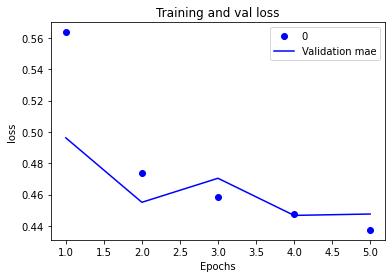

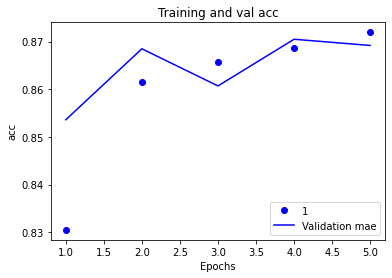

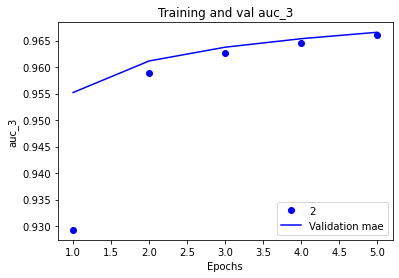

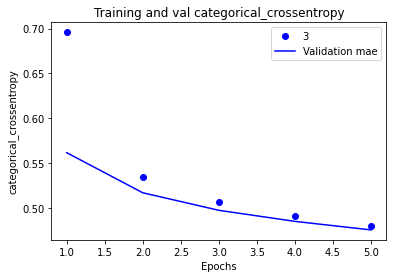

5000/5000 [==============================] - 5s 942us/step


[0.48665204820632935,
 0.8604000210762024,
 0.9665971398353577,
 0.47562915086746216]

In [18]:


# POWER MSE
# def myLoss(y_true, y_pred):
#     power = 2
#     power_loss = tf.math.abs(y_true - y_pred)**power
#     return tf.reduce_mean(power_loss, axis=-1)

myLoss = "categorical_crossentropy"

# NOTE: 'sparse_categorical_crossentropy' doesn't require one-hot encoding.  Consider for future...

# instantiate MODEL
mymodel = Model(inputs = [input_treeLocation_tensor, input_priors_tensor], 
                outputs = output_root_loc_layers)
mymodel.compile(optimizer = 'adam', 
                loss = myLoss, 
                metrics = ['acc', tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalCrossentropy()])
history = mymodel.fit([train_treeLocation_tensor, train_prior_tensor], 
                      train_labels,
                    epochs = 5, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       validation_labels))


# make history plots
cn.make_history_plot(history)

mymodel.evaluate([test_treeLocation_tensor, test_prior_tensor], test_labels)

tip frequency accuracy:  0.565294701558371
cnn prediction accuracy:  0.8082686564214644
top tip prediction accuracy:  0.6872
top cnn prediction accuracy:  0.8604


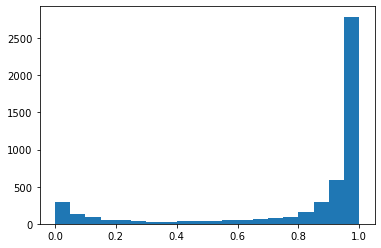

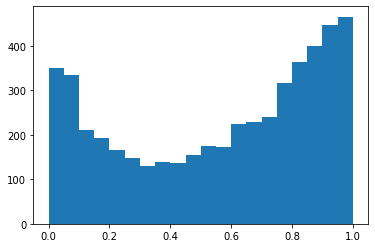

In [19]:
##################33
## TEST loc pred ###
###################
test_preds = mymodel.predict([test_treeLocation_tensor, test_prior_tensor])
nt_nv = num_test + num_validation
test_pred_labels = test_labels[:, 0:5]


# how predictive are just counts without any phylo info?
tip_loc_counts = np.zeros((test_treeLocation_tensor.shape[0],num_locs))
tip_loc_distro = np.zeros((test_treeLocation_tensor.shape[0],num_locs))
accuracy_tipfreq = np.zeros((test_treeLocation_tensor.shape[0]))
accuracy_pred = np.zeros((test_treeLocation_tensor.shape[0]))
acc_top_pred = np.zeros((test_treeLocation_tensor.shape[0]))
acc_top_tipfreq = np.zeros((test_treeLocation_tensor.shape[0]))

for i in range(0, test_treeLocation_tensor.shape[0]):    
    tip_loc_counts[i,:] = sum(test_treeLocation_tensor[i,:,2:2+num_locs])
    tip_loc_distro[i,:] = tip_loc_counts[i,:] / sum(tip_loc_counts[i,:])
    accuracy_tipfreq[i] = sum(tip_loc_distro[i,:] * test_labels[i,:])
    accuracy_pred[i] = sum(test_preds[i,:] * test_labels[i,:])
    acc_top_tipfreq[i] = 1 * (np.argmax(tip_loc_distro[i,:]) == np.argmax(test_labels[i,:]))
    acc_top_pred[i] = 1 * (np.argmax(test_preds[i,:]) == np.argmax(test_labels[i,:]))

print("tip frequency accuracy: ", np.mean(accuracy_tipfreq))
print("cnn prediction accuracy: ", np.mean(accuracy_pred))
print("top tip prediction accuracy: ", np.mean(acc_top_tipfreq))
print("top cnn prediction accuracy: ", np.mean(acc_top_pred))

 

test_accuracy = np.max(test_preds * test_labels, axis = 1)
plt.hist(test_accuracy, bins = 20, range = [0,1])
plt.show()
plt.hist(accuracy_tipfreq, bins = 20, range = [0,1])
plt.show()

import csv
mymodel.save("saved_models/MTBD_128batch_12epoch_root_location.hdf5")
# mymodel.save("saved_models/train_largerRange_128batch_10epoch_root_location.hdf5")
